# opencv + tesseract 4.0

<순서> 

image input -> text detexting -> tesseract 4.0 OCR 순으로 진행하는   
prototype을 구성해보고 발전시켜나가기로 한다

In [1]:
# 필요한 라이브러리 import

import cv2
import pytesseract
import imutils
import argparse
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import interpolation as inter

# !pip install imutils
# !pip install easydict

#argumentparser의 경우 jupyter notebook에서 error 발생
#(해결방안) easydict 사용 / 다른 프레임워크 or 터미널에서 사용

#argumentparser의 경우 대체 방안을 찾지 못해 해결 못함 - 밑으로 빼서 해결 중

In [4]:
cv2. __version__

'4.2.0'

In [3]:
#현재 디렉토리 확인 후 작업 디렉토리 변경

print("before:%s"%os.getcwd())
os.chdir("/home/qsoo/jupyter/1_opencv")
print("after: %s"%os.getcwd())

'/home/qsoo/jupyter/3_model'

shape:(830, 520, 3)
dtype:uint8


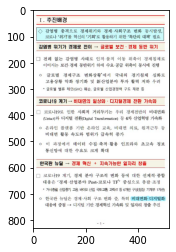

In [8]:
#이미지 가져오기

img = cv2.imread('ex.JPG')
print(f'shape:{img.shape}') #Shape: (830, 520, 3) BGR형식으로 이미지 로딩
print(f'dtype:{img.dtype}') #dtype: unint8(unsigned 8)
plt.imshow(img)

#### tesseract 성능을 올리는 방안

1.source image quality  
(input image 자체가 좋아야 된다)     

2.Scaling image to approprate size -300 dpi  
-표준규격은 아니지만 잘 작동하는 일반적인 해상도
3.De-skewing Image

4.convert Image from BGR to Gray

5.Increasing Brightness if needed

6.Image Thresholding

7.Noise removal

의 순서로 진행

In [23]:
#Scaling of image 300 DPI
"""
image size X DPI = pixel size
DPI : dot per inch, 인치 당 도트 개수

"""

# dsize = ( , ) (결과값 픽셀 사이즈) or fx = 1.2, fy = 1.2 (배수)
def imageResize(img):
  img = cv2.resize(img, dsize = (2480, 3508), 
                   interpolation=cv2.INTER_CUBIC)  #Inter Cubic 
  return img

In [24]:
#Skew Correction
def correct_skew(image, delta=1, limit=5):
    def determine_score(arr, angle):
        data = inter.rotate(arr, angle, reshape=False, order=0)
        histogram = np.sum(data, axis=1)
        score = np.sum((histogram[1:] - histogram[:-1]) ** 2)
        return histogram, score

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1] 

    scores = []
    angles = np.arange(-limit, limit + delta, delta)
    for angle in angles:
        histogram, score = determine_score(thresh, angle)
        scores.append(score)

    best_angle = angles[scores.index(max(scores))]

    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, best_angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, \
              borderMode=cv2.BORDER_REPLICATE)
    print("The Rotation angle is: ", best_angle)
    return rotated

In [25]:
#BGR to GRAY
def bgrtogrey(img):
  img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  return img

In [26]:
# Increase Brightness
def checkDayOrNight(img, thrshld):
    is_light = np.mean(img) > thrshld
    return 0 if is_light else 1 # 0 --> light and 1 -->dark

def increaseBrightness(img):
  alpha = 1 
  beta = 40
  img=cv2.addWeighted(img, alpha,np.zeros(img.shape,img.dtype), 0 ,beta)
  return img

# #if dark increase brightness
#     if checker == 1:
#       img = increaseBrightness(img) #increase brightness

In [27]:
# threshold 적용
def threshold(img):
  # Various thresholding method - 각자에 따른 장단점 존재 / 상황에 맞는 선택 필요
#   img = cv2.threshold(cv2.bilateralFilter(img, 5, 75, 75), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]  
#   img = cv2.threshold(cv2.medianBlur(img, 3), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
#   img = cv2.adaptiveThreshold(cv2.GaussianBlur(img, (5, 5), 0), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 2)
#   img = cv2.adaptiveThreshold(cv2.bilateralFilter(img, 9, 75, 75), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 2)
      img = cv2.adaptiveThreshold(cv2.medianBlur(img, 3), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 2)
      return img

In [28]:
# Noise reduction
def noise_removal(img):
  kernel = np.ones((1, 1), np.uint8)
  img = cv2.dilate(img, kernel, iterations=1)
  img = cv2.erode(img, kernel, iterations=1)
  return img

In [47]:
# pytesseract 적용하기 / kor+eng 사용 / config 값 조절하면서 적용

"""
print로 출력값만 찾는 결과 vs string으로 저장의 결과 다름 --> 해결법 찾는 중
"""


def extractinformation(img):
    config = (' -l kor+eng --oem 1 --psm 3')
    extractedInformation = pytesseract.image_to_string(img, config = config)
    print(extractedInformation)
    
#str에 pytesseract 결과값 저장

#       extractedInformation = []
#       extractedInformation = pytesseract.image_to_string(img, config = config)
#       return extractedInformation


"""
OCR Engine modes(–oem):
0 - Legacy engine only.
1 - Neural nets LSTM engine only.
2 - Legacy + LSTM engines.
3 - Default, based on what is available.

Page segmentation modes(–psm):
0 - Orientation and script detection (OSD) only.
1 - Automatic page segmentation with OSD.
2 - Automatic page segmentation, but no OSD, or OCR.
3 - Fully automatic page segmentation, but no OSD. (Default)
4 - Assume a single column of text of variable sizes.
5 - Assume a single uniform block of vertically aligned text.
6 - Assume a single uniform block of text.
7 - Treat the image as a single text line.
8 - Treat the image as a single word.
9 - Treat the image as a single word in a circle.
10 - Treat the image as a single character.
11 - Sparse text. Find as much text as possible in no particular order.
12 - Sparse text with OSD.
13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.
"""

'\nOCR Engine modes(–oem):\n0 - Legacy engine only.\n1 - Neural nets LSTM engine only.\n2 - Legacy + LSTM engines.\n3 - Default, based on what is available.\n\nPage segmentation modes(–psm):\n0 - Orientation and script detection (OSD) only.\n1 - Automatic page segmentation with OSD.\n2 - Automatic page segmentation, but no OSD, or OCR.\n3 - Fully automatic page segmentation, but no OSD. (Default)\n4 - Assume a single column of text of variable sizes.\n5 - Assume a single uniform block of vertically aligned text.\n6 - Assume a single uniform block of text.\n7 - Treat the image as a single text line.\n8 - Treat the image as a single word.\n9 - Treat the image as a single word in a circle.\n10 - Treat the image as a single character.\n11 - Sparse text. Find as much text as possible in no particular order.\n12 - Sparse text with OSD.\n13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.\n'

### 함수 실행하기

shape:(3508, 2480, 3)
dtype:uint8


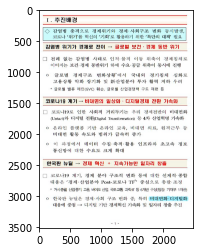

In [31]:
'''
1. image resize
a4 size / 300dpi 에 맞춰서 2480 X 3508 pixel size로 재설정
'''

img_resize = imageResize(img)

print(f'shape:{img_resize.shape}') #Shape: (3508, 2480, 3) BGR형식으로 이미지 로딩
print(f'dtype:{img_resize.dtype}') #dtype: unint8(unsigned 8)
plt.imshow(img_resize)

The Rotation angle is:  0


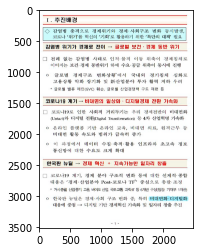

In [32]:
#reskew
img_reskew = correct_skew(img_resize)

plt.imshow(img_reskew)

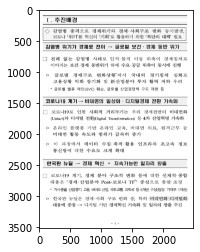

In [33]:
# BGR to Gray

img_gray = bgrtogrey(img_reskew)

plt.imshow(img_gray, cmap = 'gray')

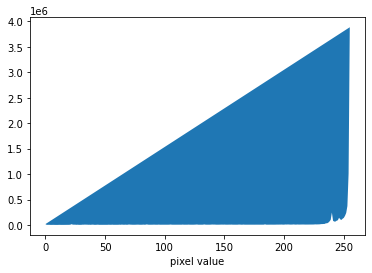

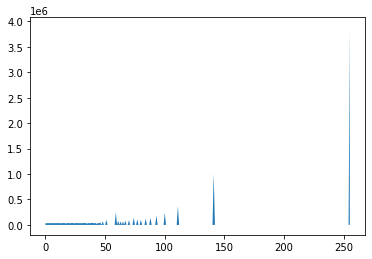

In [36]:
# threshold 탐색
"""
ex.JPG의 경우 global threshold의 직접 탐색의 어려움 + 의미없음
adaptive threshold 적용키로
"""

hist, bins = np.histogram(img_gray, 256, [0,255])
plt.fill(hist)
plt.xlabel('pixel value')
plt.show()

#threshold 평활화

hist_equal = cv2.equalizeHist(img_gray)
hist, bins = np.histogram(hist_equal, 256, [0,255])
plt.fill_between(range(256), hist, 0)
plt.show()

In [41]:
# check Brightness
"""
0 -> Light / 1 -> Dark
threshold 기준으로 나눈 것이라 threshold를 정하기 어려울 때는 체크의 의미 무효
"""


checkDayOrNight(img_gray, 150)

# increase Brightness
'''
if Dark - increaseBrightness 함수 적용

# img_bright = increaseBrightness(img_gray)

'''

'\nif Dark - increaseBrightness 함수 적용\n\n# img_thr = increaseBrightness(img1)\n\n'

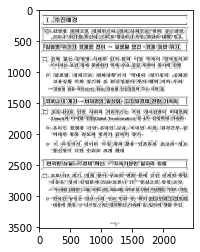

In [42]:
#threshold 적용

img_thr = threshold(img_gray)

plt.imshow(img_thr, cmap = 'gray')

(-0.5, 2479.5, 3507.5, -0.5)

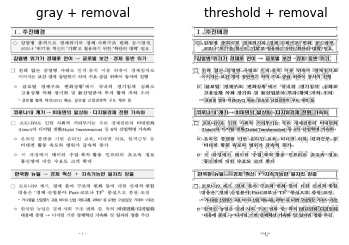

In [45]:
#noise remove


# gray + noise removal vs threshold + noise removal의 결과값을 비교해보자

img_noise_removal = noise_removal(img_gray)
img_noise_removal2 = noise_removal(img_thr)

fig = plt.figure()
rows = 1
cols = 2

ax1 = fig.add_subplot(rows,cols,1)
ax1.imshow(img_noise_removal, cmap = "gray")
ax1.set_title('gray + removal')
ax1.axis('off')

ax2 = fig.add_subplot(rows,cols,2)
ax2.imshow(img_noise_removal2, cmap = "gray")
ax2.set_title('threshold + removal')
ax2.axis('off')

# plt.show()
# plt.imshow(img_noise, cmap = 'gray')

In [46]:
# # 출력값 파일로 저장해서 확인 - gray의 경우 더욱 clear

# cv2.imwrite('gray_removal.png', img_noise_removal, [cv2.IMWRITE_PNG_COMPRESSION, 0])
# cv2.imwrite('threshold_removal.png', img_noise_removal2, [cv2.IMWRITE_PNG_COMPRESSION, 0])

True

In [48]:
# gray + noise removal 

extractinformation(img_noise_removal)

[. 추 진 배 경

<> 감염병 충 격 으로 경 제 위 기와 경 제 - 사 회 구 조 변화 동 시 발 생 ,
코로나 " 위 가 ' 를 혁 신 의 " 기 회 " 로 활 용 하기 위한 " 특 단 의 대 책 ' 필요

감염병 위 기 가 경 제 로 전이 ㅡ 글로벌 보건 ㆍ 경 제 동반 위기
니 전례 없는 감염병 사 태 로 인 적 - 물 적 이동 위 축 어 경 제 침 체 로
이어지는 보 건 - 경 제 동 반 위기 하에 수 요 - 공 급 위 축 이 동시에 진행

ㅇ 글로벌 경 제 구조 변 화 상 황 에서 국내외 경 기 침 체 심 화 로
고 용 상황 악화 장기화 및 핸 산 업 분야 투자 활력 저하 우려

* 글로벌 밸류 체 인 (5\ ㅇ ) 훼손, 글로벌 산 업 경쟁력 구도 재편 등

코 로 나 19 계기 ㅡ 비 대 면 의 일 상 화 ㆍ 디 지 털 경 제 전환 가속화

니 코 로 나 19 로 인한 사회적 거 리 두 기는 우리 경 제 전 반 의 비 대 면화
(0866 와 디지털 전 환 ( ㅁ 8 1309005088007 ㅎ 4 차 산 업 혁명 가속화

ㅇ 온라인 플랫폼 기반 온라인 교육, 비 대 면 의료, 원 격 근무 등
비 대 면 활동 GES 범 위 가 급속히 중가

ㅇ 이 과 정 에서 데이터 수 집 - 축 적 - 활 용 인 프 라 와 초고속 정보
통 신 망 에 대한 수 요 도 크게 확대

한국판 뉴딜 ㅡ 경제 혁신 + 지 속 가능한 일자리 창출

니 코 로 나 19 계기, 경제 분야 구조적 변화 등에 대한 선 제 적 - 종 합
대 응 은 " 경 제 - 산 업 분야 865&6 코 로나 76" 중 심 으로 총 괄 - 조 정
* 거 사 총 괄 산 업 중기 고용 바이오 산업 국 토 교통 과학 등 6 개 반 구 성 (팀장 기 재 부 1 차 괜

ㅇ 한국판 뉴 딜 은 경 제 - 사 회 구조 변화 중 특히 비 대 면 화 - 디 지 털 화
대 응 에 중점 ㅡ * 디지털 기반 경 제 혁신 가속화 및 일자리 창출 추진


In [49]:
# threshold + noise removal 

extractinformation(img_noise_removal2)

> OE ————————————————————————————————————— 몰
‘ = 5 aN ee Oy, 4

(7 Sana
[e2 ane SACS BAZ: A Als eS SA:

2250

: a [를 희 신 의 ,( ast So e880718 citadel eee: .

 

a aa @ee : 감 염 병 5 사 태 로: 인 적 * 물 적 : 6267 ' 위 축 이 평 제 취 체 로

＊ 이 어 지 는: 보건: 경제 동 반 위기 하에; a. SARS] 동시에: 진행

oi ew BAR Mees “Sus: cna : 성 화보
USAR SP B78 SL MAU ARE AA Fe

ela lees,

\,

Ol 코 로 니 19 로 : 인한 차 회 적 : 거 리 두 기 는: 우리 경 제 전 반 의 ' 비 대 면화:
“Ga ates AS} Digital: Transformations = az} 산 업 혁명 가속화:

ㅇ 5 온 라인: 플랫폼 기반 Eek: SHS ALO : 의 료 >. ASF es

" 비 대 편 : 활동 seo 범 위 가 BAe] Ske

9% 의 : 과 정 에 서 , 테 이 터 수집: BAe Sheol web op order wa:
“walnboi Wek Secs 크게 확대

Oe

1: . 코 로 나 49% 계기, Bal. LORY 구조적: "변화 Sol) 대한 선 제 적 : 종합:
ase eal: absleck pase Teel ee oe: Bs

rs

oe ee ae. Adio aft 25 ss Be ssl 이 베 베 변 959 피 보 00
“ 대 응 에 - 중 점 >>* 너 지 털 운 ] 반 ) 경 제 혁 신 5} 속 화 ? 및 : 일 자 리 / 창 출 " 추 진 。

wo sent

—_ _ ㅡ

t—s1-.
we
oO,


In [54]:
# 위의 결과값 상당히 안좋기 때문에 kor만 적용한 tesseract도 적용해보기로

print(pytesseract.image_to_string(img_noise_removal2, config='-l kor --oem 1 --psm 3'))

# 결과가 안 좋기 때문에 threshold를 수정하여 선택하는 방안에 대해 생각할 필요 존재(진행중)

; 〉 ㅜ 11111 ㅣ ， ㅣ ㅋ 그 몰
: = 3 새시 아 10 네 비 여는 개. 에

： 』. 추 진 배 경
[9 벽 . 자 영 78 충 격 으로 . 경 제 위 기와 8 경 제 8% 사 회 구 속 :' 변 화 : 중 신 발 생 )

2250

. 내 (9 가 을 [를 희 신 의 ,( 1.21 와 균 88016 ' 위 해 0 단 의 15 취 7 위 이 '

 

ㅁ 엿 헤 혔 는 48 : 감 염 병 5 사 태 로: 인 적 * 물 적 : 6267 ' 위 축 이 평 제 취 체 로

＊ 이 어 지 는: 보건: 경제 동 반 위기 하에; 수 요 : 콩 공 급 > 위 축 이 동시에: 진행

이 . 블 모병; 팽 페 구 = 변 화 장 황 "에서 "국내외 : 맹 키 천체! : 성 화보
고 .85 창 화 와 화 장기화 미 취 잔 입 몬 야 : 투 자 > 환 디 " 저 하 : 수 며 :

…2】`= ㅎ

마

; 니 ' 코 로 니 19 로 : 인한 차 회 적 : 거 리 두 기 는: 우리 경 제 전 반 의 ' 비 대 면화:
" 때 쁘 바 . 디 지 털 ) 숫 선 환 (20488 10858989889937 4 차 ' 산 업 혁명 가속화:

ㅇ 5 온 라인: 플랫폼 기반 :- 인 라 : 인 호 : 교 육 5< 비 대면) : 의 료 >. { 원 격 은 무 6 동

" 비 대 편 : 활동 족 도와 범 위 가 급 쑥 히 중 각 5

이 의 : 과 정 에 서 , 테 이 터 수집: : 축 적 " ` 활 : 용 ㅋ 인 프 라 와 : 초 코 속 * 정 보 :
" 통 진 팡 에) 대한. 수 요 노 크게 확대

-~>558988598988986080

8 . 코 로 나 49% 계기, . 령 제. 1 분 야니 구조적: "변화 등에: 대한 선 제 적 : 종합:
. 대 응 온 경계: 잔 연 분 88 '2088 코 로나, 8 좋 쉬 으 리 총괄 족 8

6 디 시니

2 = 한 득 푸 뉴 덤 은 레게 자 회 := 25 … 빈 확 ) : 금 나 복리 이 베 베 변 959 피 보 00
“ 대 응 에 - 중

추가 진행 예정 사항  

(1)전체를 묶었을 때 각 처리 과정에서 적용해야 할 input과 적용하지 않을 input을 통과시켜야함  

(2)one click 실행방안에 대해 생각해봐야함  

(3)결과 파일 저장을 어디에 넣어서 무엇으로 추출할지 고민  

(4)pdf,word, hwp 등을 image(png, jpg, jpeg 등)으로 변환을 어떻게 할지 고민해봐야 함 

(5)evaluating 방식 - test input을 우리가 typing해서 비교할 자료를 가지고 있어야한다(직접? / 얻을 수 있는 방법 존재?)

In [56]:
# 해당 argumentParser의 경우 easydict 및 기타 프레임워크에서 작동하는 방안 탐구중
# 원 클릭 작동을 위해 


'''
# construct the argument parser and parse the arguments
ap = argparse.ArgumentParser("")
ap.add_argument("-i", "--image", type=str,
	help="path to input image")
ap.add_argument("-east", "--east", type=str,
	help="path to input EAST text detector")
ap.add_argument("-c", "--min-confidence", type=float, default=0.5,
	help="minimum probability required to inspect a region")
ap.add_argument("-w", "--width", type=int, default=320,
	help="resized image width (should be multiple of 32)")
ap.add_argument("-e", "--height", type=int, default=320,
	help="resized image height (should be multiple of 32)")
args = vars(ap.parse_args())

if __name__ == '__main__':
    
    if len(sys.argv) < 2:
        print('Usage: python ocr_simple.py image.jpg')
        sys.exit(1)
'''

# 코드 참조 : https://medium.com/@rishabharya2799/creating-a-complete-and-most-efficient-pipeline-in-opencv-for-tesseract-ocr-737e6bf54bcb


'\n# construct the argument parser and parse the arguments\nap = argparse.ArgumentParser("")\nap.add_argument("-i", "--image", type=str,\n\thelp="path to input image")\nap.add_argument("-east", "--east", type=str,\n\thelp="path to input EAST text detector")\nap.add_argument("-c", "--min-confidence", type=float, default=0.5,\n\thelp="minimum probability required to inspect a region")\nap.add_argument("-w", "--width", type=int, default=320,\n\thelp="resized image width (should be multiple of 32)")\nap.add_argument("-e", "--height", type=int, default=320,\n\thelp="resized image height (should be multiple of 32)")\nargs = vars(ap.parse_args())\n\nif __name__ == \'__main__\':\n    \n    if len(sys.argv) < 2:\n        print(\'Usage: python ocr_simple.py image.jpg\')\n        sys.exit(1)\n'